In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
tfds.disable_progress_bar()

dataset , metadata = tfds.load('mnist', as_supervised = True, with_info = True)

train_data , test_data = dataset['train'], dataset['test']

class_names = metadata.features['label'].names


print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
metadata

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
print('No. of train data ', metadata.splits['train'].num_examples)
print('No. of test data ', metadata.splits['test'].num_examples)

No. of train data  60000
No. of test data  10000


In [5]:
BATCH_SIZE = 32

train_data = train_data.cache().batch(BATCH_SIZE)
test_data = test_data.cache()

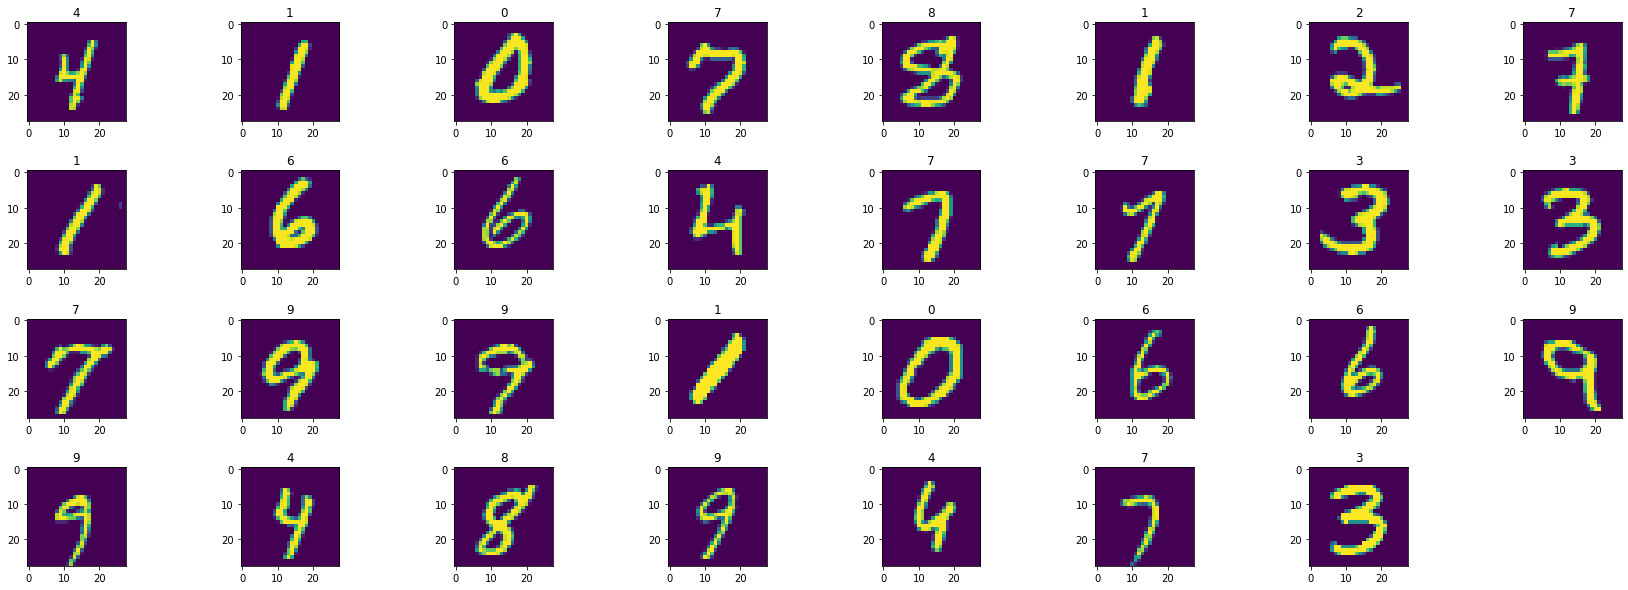

In [6]:
fig = plt.figure(figsize= (30,10))
fig.subplots_adjust(hspace =0.5)

for images, labels in train_data.take(1):
  for i in range(31):
    ax = fig.add_subplot(4, 8, i + 1)
    plt.imshow(images[i][:,:,0].numpy())
    plt.title(labels[i].numpy())


In [7]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_data = train_data.map(normalize)

In [8]:
validation_data = test_data.take(300).batch(BATCH_SIZE)
test_data = test_data.skip(300)

In [9]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

EPOCH = 20

model = keras.models.Sequential(layers=[
        keras.layers.Conv2D(filters = 4, kernel_size = (3,3), strides = (1,1),
                        activation = tf.nn.relu, input_shape = (28,28,1)
                        ), 
    keras.layers.MaxPool2D((2,2), strides= (1,1)),

     keras.layers.Conv2D(filters = 4, kernel_size = (3,3), strides = (1,1),
                        activation = tf.nn.tanh
                        ), 
    keras.layers.MaxPool2D((2,2), strides= (2,2)), 

    keras.layers.Flatten(), 

    keras.layers.Dense(1936, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1936, activation = tf.nn.tanh),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])


loss = keras.losses.SparseCategoricalCrossentropy()
model.compile(
    loss = loss, 
    optimizer = 'adam',
    metrics = ['accuracy']
)

early_stop = keras.callbacks.EarlyStopping(patience = 5)
save_model = keras.callbacks.ModelCheckpoint('model.h5')

print(model.summary())

history = model.fit(
 train_data, 
 epochs = EPOCH,
 validation_data = validation_data,
 callbacks = [early_stop, save_model]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 4)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 484)               0         
                                                                 
 dense (Dense)               (None, 1936)              9

In [10]:
model.evaluate(validation_data)

10/10 [==============================] - 0s 4ms/step - loss: 0.3913 - accuracy: 0.9567


[0.391263872385025, 0.9566666483879089]

In [11]:
saved_model = keras.models.load_model('./model.h5')

In [12]:
saved_model.evaluate(test_data.batch(BATCH_SIZE))

304/304 [==============================] - 2s 4ms/step - loss: 0.3885 - accuracy: 0.9480


[0.38852447271347046, 0.9480412602424622]

In [13]:
model.evaluate(test_data.batch(BATCH_SIZE))

304/304 [==============================] - 1s 3ms/step - loss: 0.3885 - accuracy: 0.9480


[0.38852447271347046, 0.9480412602424622]

In [14]:
prediction = saved_model.predict(test_data.batch(BATCH_SIZE))

304/304 [==============================] - 1s 2ms/step


In [15]:
prediction.shape

(9700, 10)

Text(0.5, 0, '9')

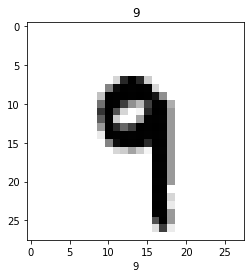

In [16]:
for image, label in test_data.take(1):
  break
plt.imshow(image[:,:,0], cmap = plt.cm.binary)
plt.title(label.numpy())
plt.xlabel(prediction[0].argmax())